## Importing libraries

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import imageio

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Build data loading functions

In [3]:
# import gdown
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [4]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
vocab = [x for x in 'abcdefghijklmnopqrstuvwxyz?!123456789 ']
print(vocab)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']


In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),
                                           oov_token="",
                                           invert=True
                                          )

print(f"The vocabulary is : {char_to_num.get_vocabulary()}"
      f"(size ={char_to_num.vocabulary_size()} )")

The vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =39 )


In [7]:
char_to_num(['a', 'd', 'e', 'g'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 4, 5, 7], dtype=int64)>

In [8]:
num_to_char([1, 4, 5, 7])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'd', b'e', b'g'], dtype=object)>

In [9]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'),(-1)))[1:]

In [10]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    print('path', path)
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [11]:
path = ".\\data\\s1\\bbaf2n.mpg"

In [12]:
tf.convert_to_tensor(path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

''

In [13]:
frames, alignments = load_data(tf.convert_to_tensor(path))

path .\data\s1\bbaf2n.mpg


In [14]:
frames[38]

<tf.Tensor: shape=(46, 140, 1), dtype=float32, numpy=
array([[[1.4991663 ],
        [1.4991663 ],
        [1.4991663 ],
        ...,
        [0.3373124 ],
        [0.29983324],
        [0.3373124 ]],

       [[1.4991663 ],
        [1.4991663 ],
        [1.4991663 ],
        ...,
        [0.3373124 ],
        [0.3373124 ],
        [0.3373124 ]],

       [[1.4616871 ],
        [1.4616871 ],
        [1.4242079 ],
        ...,
        [0.3373124 ],
        [0.3373124 ],
        [0.3373124 ]],

       ...,

       [[0.97445804],
        [0.97445804],
        [0.97445804],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.97445804],
        [0.97445804],
        [0.97445804],
        ...,
        [0.        ],
        [0.        ],
        [9.557184  ]],

       [[0.97445804],
        [0.97445804],
        [0.97445804],
        ...,
        [0.        ],
        [9.557184  ],
        [9.557184  ]]], dtype=float32)>

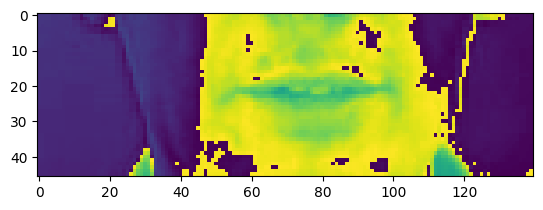

In [15]:
plt.imshow(frames[38])

In [16]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 38,  2, 12, 21,  5, 38,  1, 20, 38,  6, 38, 20, 23, 15,
       38, 14, 15, 23], dtype=int64)>

In [17]:
tf.strings.reduce_join(([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]))

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [18]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Data Pipeline

In [19]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [20]:
frames, alignment = data.as_numpy_iterator().next()

path .\data\s1\swwc5s.mpg
path .\data\s1\swbv5a.mpg
path .\data\s1\srbh8n.mpg


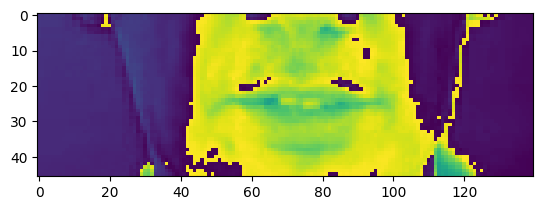

In [21]:
plt.imshow(frames[0][40])

In [22]:
alignment

array([[19,  5, 20, 38, 23,  8,  9, 20,  5, 38, 23,  9, 20,  8, 38,  3,
        38,  6,  9, 22,  5, 38, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 38, 23,  8,  9, 20,  5, 38,  2, 25, 38, 22, 38,  6,
         9, 22,  5, 38,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [23]:
test = data.as_numpy_iterator()
val = test.next()

path .\data\s1\bbbmzn.mpg
path .\data\s1\lwwm3a.mpg
path .\data\s1\bgahzn.mpg


In [24]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.946452140808105]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.946452140808105]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.946452140808105]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.946452140808105]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.946452140808105]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.946452140808105]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.946452140808105]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

path .\data\s1\sgap3a.mpg


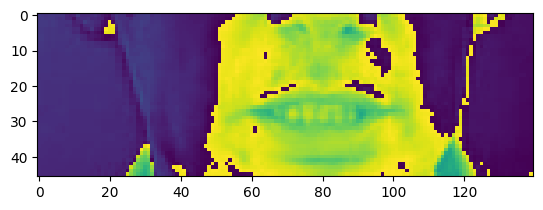

In [25]:
plt.imshow(val[0][1][40])

In [26]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by m zero now'>

## Design the Deep Neural Network

In [27]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [28]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [30]:
y_hat = model.predict(val[0])
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in y_hat[1]])

1/1 [==============================] - 8s 8s/step


<tf.Tensor: shape=(), dtype=string, numpy=b'gggbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb  '>

In [31]:
model.input_shape

(None, 75, 46, 140, 1)

In [32]:
model.output_shape

(None, 75, 40)

## Setup Training options and Train

In [33]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [48]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [49]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        y_hat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(y_hat, [75, 75], greedy=False)[0][0].numpy()
        for x in range(len(y_hat)):
                print("Original: ", tf.strings.reduce_join(num_to_char(data[1][x])).numpy.decode('utf-8'))
                print("Prediction: ", tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
                print('~'*100)

In [50]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [51]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor='loss', save_weights_only=True)

In [52]:
schedule_callback = LearningRateScheduler(scheduler)

In [53]:
example_callback = ProduceExample(data)

In [56]:
model.fit(data, epochs=100, batch_size=32, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
path .\data\s1\lbij7s.mpg
path .\data\s1\lbbezn.mpg
path .\data\s1\briz6n.mpg
path .\data\s1\lgamzp.mpg


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/max_pooling3d_1/MaxPool3D' defined at (most recent call last):
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\FARZIN\AppData\Local\Temp\ipykernel_18068\3135355164.py", line 1, in <module>
      model.fit(data, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\layers\pooling\base_pooling3d.py", line 88, in call
      outputs = self.pool_function(
Node: 'sequential/max_pooling3d_1/MaxPool3D'
Detected at node 'sequential/max_pooling3d_1/MaxPool3D' defined at (most recent call last):
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\FARZIN\AppData\Local\Temp\ipykernel_18068\3135355164.py", line 1, in <module>
      model.fit(data, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FARZIN\anaconda3\envs\lip_net\lib\site-packages\keras\layers\pooling\base_pooling3d.py", line 88, in call
      outputs = self.pool_function(
Node: 'sequential/max_pooling3d_1/MaxPool3D'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[2,256,75,23,70] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/max_pooling3d_1/MaxPool3D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[CTCLoss/Log/_66]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[2,256,75,23,70] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/max_pooling3d_1/MaxPool3D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_30944]

In [60]:
! pip freeze > requirements.txt
